Here, I tested alpha #2 published by Kakushadze at https://arxiv.org/pdf/1601.00991.pdf.

In [5]:
from zipline.api import (
    attach_pipeline,
    date_rules,
    order_target_percent,
    pipeline_output,
    record,
    schedule_function,
)
from zipline.finance import commission, slippage
from zipline.pipeline import Pipeline
from zipline.pipeline.factors import CustomFactor
from zipline.pipeline.data import EquityPricing

from zipline import run_algorithm
import pandas as pd
import numpy as np
import pandas_datareader.data as web

import matplotlib.pyplot as plt

# import warnings
# warnings.filterwarnings("ignore", category=RuntimeWarning, module="numpy")

STARTING_CASH = 1e5

class Alpha2(CustomFactor):
    """
    **Default Inputs**: :data:`zipline.pipeline.data.EquityPricing.open, close, and volume`

    **Default Window Length**: 8
    """

    window_length = 8
    inputs = (EquityPricing.open,EquityPricing.close,EquityPricing.volume,)
    window_safe = True
    
    def compute(self, today, assets, out, opens, closes, volumes):
        n_of_assets = len(assets)
        
        volumes = np.log(volumes)
        arr_left = n_of_assets-np.argsort(volumes[2:]-volumes[:-2],axis=1)
        
        arr_right = n_of_assets-np.argsort((closes[2:]-opens[2:])/opens[2:],axis=1)
        
        out[:] = -np.corrcoef(arr_left, arr_right, rowvar=False)[n_of_assets:,0:n_of_assets].diagonal()

class MinOfPriceMultiVol(CustomFactor):
    """
    In essence, I created this Factor/Filter to avoid buying stocks that the market was uninterested in,
    ie, those trading with low volumns. Such low liquidity would cause problems. 
    """
    
    window_length = 10
    inputs = (EquityPricing.close,EquityPricing.volume,)
    window_safe = True
    
    def compute(self, today, assets, out, closes, volumes):
        out[:] = np.nanmin(closes*volumes, axis=0)

def make_pipeline():
    alpha2 = Alpha2()
    return Pipeline(
        columns={
            "longs": alpha2.top(10),
        },
        screen=MinOfPriceMultiVol() > STARTING_CASH * 100,
        # the scalar above is manually adjusted based on universe size
        # if *1000, we have about 100-300 assets in universe
        # if *100, we have 1000-2000 assets
    )


def rebalance(context, data):
    pipeline_data = context.pipeline_data
    
    all_assets = pipeline_data.index

    longs = all_assets[pipeline_data.longs]

    record(universe_size=len(all_assets))

    for asset in longs:
        order_target_percent(asset, 1.0/20.0) # 1/2 portfolio for long, 1/2 portfolio in cash

    portfolio_assets = longs
    
    positions = context.portfolio.positions
    
    # see all other stocks that were longed
    for asset in positions.keys() - set(portfolio_assets):
        # This will fail if the asset was removed from our portfolio because it
        # was delisted.
        if data.can_trade(asset):
            order_target_percent(asset, 0)


def initialize(context):
    attach_pipeline(make_pipeline(), "my_pipeline")

    # Rebalance each day.  In daily mode, this is equivalent to putting
    # `rebalance` in our handle_data, but in minute mode, it's equivalent to
    # running at the start of the day each day.
    schedule_function(rebalance, date_rules.every_day())
    
    # assume commission scales with the tollar dollar transacted
#     context.set_commission(commission.PerDollar(cost=3e-4))
    # assume price executed is a quadratic function of volume share
    # because the volume share is usually minimal, slippage is almost nothing
    context.set_slippage(slippage.VolumeShareSlippage())

def before_trading_start(context, data):
    
    context.pipeline_data = pipeline_output("my_pipeline")


start = pd.Timestamp('2017-01-01')
end = pd.Timestamp('2017-12-30')

sp500 = web.DataReader('SP500', 'fred', start, end).SP500
benchmark_returns = sp500.ffill().pct_change()

result = run_algorithm(start=start,#.tz_localize('UTC')
                       end=end,#.tz_localize('UTC')
                       initialize=initialize,
                       before_trading_start=before_trading_start,
                       capital_base=STARTING_CASH,
                       benchmark_returns=benchmark_returns,
                       bundle='quandl',
                       data_frequency='daily')

/var/folders/h0/0qvqyxfx4rv03h7hnykyft2r0000gp/T/ipykernel_5032/3325273989.py:40: RuntimeWarning: divide by zero encountered in log
  volumes = np.log(volumes)
/var/folders/h0/0qvqyxfx4rv03h7hnykyft2r0000gp/T/ipykernel_5032/3325273989.py:41: RuntimeWarning: invalid value encountered in subtract
  arr_left = n_of_assets-np.argsort(volumes[2:]-volumes[:-2],axis=1)
/var/folders/h0/0qvqyxfx4rv03h7hnykyft2r0000gp/T/ipykernel_5032/3325273989.py:58: RuntimeWarning: All-NaN slice encountered
  out[:] = np.nanmin(closes*volumes, axis=0)
/var/folders/h0/0qvqyxfx4rv03h7hnykyft2r0000gp/T/ipykernel_5032/3325273989.py:40: RuntimeWarning: divide by zero encountered in log
  volumes = np.log(volumes)
/var/folders/h0/0qvqyxfx4rv03h7hnykyft2r0000gp/T/ipykernel_5032/3325273989.py:41: RuntimeWarning: invalid value encountered in subtract
  arr_left = n_of_assets-np.argsort(volumes[2:]-volumes[:-2],axis=1)
/var/folders/h0/0qvqyxfx4rv03h7hnykyft2r0000gp/T/ipykernel_5032/3325273989.py:58: RuntimeWarning: All

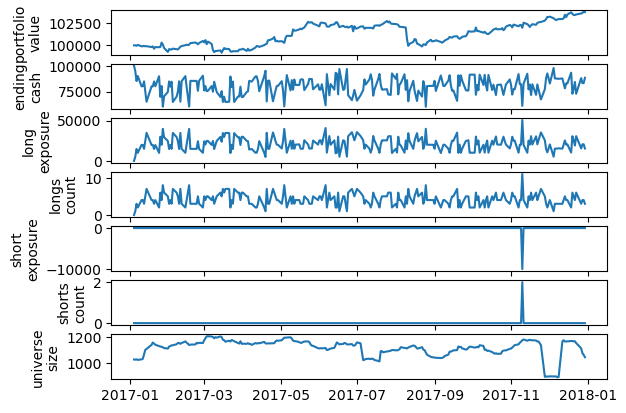

In [6]:
cols_to_plot = ['portfolio_value','ending_cash','long_exposure','longs_count','short_exposure','shorts_count',
               'universe_size']
fig, axes = plt.subplots(7, 1, sharex=True)
for i, col_i in enumerate(cols_to_plot):
    axes[i].plot(result[col_i])
    axes[i].set_ylabel(col_i.replace('_','\n'))

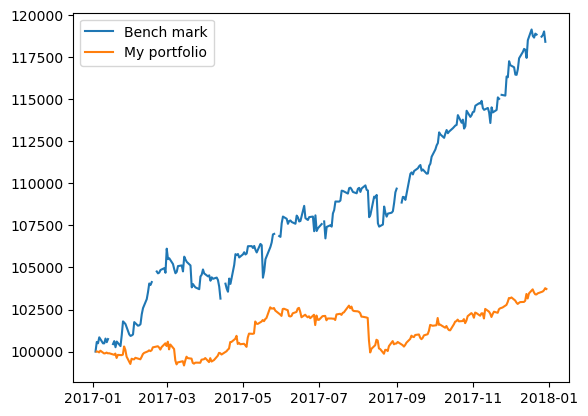

In [15]:
fig, ax = plt.subplots()
ax.plot((STARTING_CASH/sp500[1]*sp500),label='Bench mark')
ax.plot(result.portfolio_value,label='My portfolio')
ax.legend()